# 1. Descargar datos

En este script se descargaran los datos desde el 01-01-2020 hasta el 31-12-2024 de todas las empresas que forman el NASDAQ100

In [2]:
!pip install yfinance pandas numpy PyPortfolioOpt matplotlib Riskfolio-Lib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.6/314.6 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 978.3/978.3 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.1/222.1 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.6/293.6 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.3/172.3 kB 13.8 MB/s eta 0:00:00


In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
from pypfopt import EfficientFrontier, risk_models, expected_returns
import matplotlib.pyplot as plt
from datetime import datetime
import requests
import riskfolio as rp
from scipy.stats import gaussian_kde

In [4]:
# Definimos las fechas
start_date = "2020-01-01"
end_date = "2024-12-31"

## Funciones a definir

In [5]:
# Function to scrape NASDAQ-100 tickers from Wikipedia
def scrape_nasdaq100_tickers():
    url = "https://en.wikipedia.org/wiki/Nasdaq-100"
    try:
        # Send HTTP request with a user-agent to avoid being blocked
        headers = {
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/92.0.4515.107 Safari/537.36"
        }
        response = requests.get(url, headers=headers)
        if response.status_code != 200:
            raise ValueError(f"Failed to fetch page: Status code {response.status_code}")

        # Read the table with NASDAQ-100 constituents
        tables = pd.read_html(response.text, attrs={"id": "constituents"})
        if not tables:
            raise ValueError("No tables found with id 'constituents'")

        # Extract tickers from the 'Ticker' column
        df = tables[0]
        tickers = df["Ticker"].tolist()
        print(f"Scraped {len(tickers)} NASDAQ-100 tickers from Wikipedia")
        return tickers
    except Exception as e:
        print(f"Error scraping tickers: {e}")
        return []

# Function to extract Close prices for optimization
def extract_adj_close(all_data):
    adj_close = pd.DataFrame()
    for ticker in set(col[0] for col in all_data.columns):
        try:
            adj_close[ticker] = all_data[ticker]["Adj Close"]
        except KeyError:
            print(f"Adj Close for {ticker} not available.")
    return adj_close

    # Function to check if covariance matrix is positive definite
def is_positive_definite(matrix):
    try:
        np.linalg.cholesky(matrix)
        return True
    except np.linalg.LinAlgError:
        return False

In [6]:
# Scrape NASDAQ-100 tickers
print("Scraping NASDAQ-100 tickers...")
tickers = scrape_nasdaq100_tickers()
if not tickers:
    print("Failed to scrape tickers. Exiting.")
    exit()

Scraping NASDAQ-100 tickers...
Scraped 101 NASDAQ-100 tickers from Wikipedia


/tmp/ipython-input-321586833.py:14: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  tables = pd.read_html(response.text, attrs={"id": "constituents"})


In [7]:
data = yf.download(tickers, start=start_date, end=end_date,group_by='tickers', auto_adjust=False)
# Get only 2 decimals
data = data.round(decimals=2)
data.to_csv("nasdaq100_stock_data.csv")

[*********************100%***********************]  101 of 101 completed


In [8]:
# Check if all tickers in data are in tickers
missing_tickers = [ticker for ticker in tickers if ticker not in data.columns.levels[0]]
if missing_tickers:
    print(f"Missing tickers: {missing_tickers}")

In [9]:
prices = extract_adj_close(data)

/tmp/ipython-input-321586833.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adj_close[ticker] = all_data[ticker]["Adj Close"]


## Cálculo de cartera

In [10]:
# Remove stocks with missing data
prices = prices.dropna(axis=1, how="any")
valid_tickers = prices.columns
print(f"Stocks with complete data: {len(valid_tickers)}")

Stocks with complete data: 93


In [17]:
# =========================
# Portfolio optimization + metrics with riskfolio - CORREGIDO
# =========================
import numpy as np
import pandas as pd
import riskfolio as rp

# --- Parámetros ---
start_date = "2020-01-01"
end_date = "2024-12-31"
risk_free_rate_annual = 0.04 # ajusta si quieres
risk_free_rate_daily = (1 + risk_free_rate_annual) ** (1/252) - 1

print(f"Tasa libre de riesgo anual: {risk_free_rate_annual:.2%}")
print(f"Tasa libre de riesgo diaria: {risk_free_rate_daily:.6f}")

# --- 1) Retornos diarios a partir de precios ---
prices_ = prices.loc[start_date:end_date]
returns = prices_.pct_change().dropna(how="all") # (T x N)

print(f"\nDatos del período: {start_date} a {end_date}")
print(f"Número de días de trading: {len(returns)}")
print(f"Número de activos: {returns.shape[1]}")

# --- 2) Crear portafolio y estimar momentos ---
port = rp.Portfolio(returns=returns)

# Media histórica y covarianza Ledoit-Wolf (robusta)
port.assets_stats(method_mu="hist", method_cov="ledoit")

# --- 3) Optimización: Máximo Sharpe (modelo clásico, varianza) ---
# rm="MSV" (semivarianza). Si prefieres varianza, usa rm="MV".
w_df = port.optimization(
    model="Classic",
    rm="MSV",
    obj="Sharpe",
    rf=risk_free_rate_daily,
    l=0, # long-only
    hist=True # usa toda la historia suministrada
)

# Extraer pesos como Series (index = tickers)
w = w_df.T.squeeze().reindex(returns.columns).fillna(0)

# (opcional) filtrar pesos muy pequeños
w = w[w > 1e-4]
w = (w / w.sum()).reindex(returns.columns).fillna(0) # re-normaliza por si filtraste

print("\nPesos del portafolio (ordenados):")
print(w[w>0].sort_values(ascending=False))
print(f"Suma de pesos: {w.sum():.6f}")

# --- 4) Retornos y métricas de la cartera ---
port_ret = returns.dot(w) # retorno diario
excess_ret = port_ret - risk_free_rate_daily # exceso sobre rf

print(f"\nEstadísticas de los retornos del portafolio:")
print(f"Retorno medio diario: {port_ret.mean():.6f}")
print(f"Volatilidad diaria: {port_ret.std(ddof=1):.6f}")
print(f"Exceso de retorno medio diario: {excess_ret.mean():.6f}")

# --- CÁLCULO CORRECTO DEL SHARPE RATIO ---
# Método 1: Directamente con los retornos diarios de exceso
sharpe_method1 = excess_ret.mean() / excess_ret.std(ddof=1) * np.sqrt(252)

# Método 2: Anualizando por separado (más claro)
mean_excess_annual = excess_ret.mean() * 252
std_excess_annual = excess_ret.std(ddof=1) * np.sqrt(252)
sharpe_method2 = mean_excess_annual / std_excess_annual

# Método 3: Usando retornos anualizados del portafolio
port_ret_annual = port_ret.mean() * 252
port_vol_annual = port_ret.std(ddof=1) * np.sqrt(252)
sharpe_method3 = (port_ret_annual - risk_free_rate_annual) / port_vol_annual

# Verificación con riskfolio
try:
    # Riskfolio también puede calcular métricas
    portfolio_stats = rp.RiskFunctions.Sharpe(w, port.mu, port.cov, port.returns, rf=risk_free_rate_daily)
    sharpe_riskfolio = portfolio_stats * np.sqrt(252)  # Anualizarlo si es necesario
except:
    sharpe_riskfolio = None

# --- Otras métricas ---
equity = (1 + port_ret).cumprod()
total_return = equity.iloc[-1] - 1
n_years = len(port_ret) / 252
cagr = (1 + total_return) ** (1 / n_years) - 1

# Máximo drawdown
running_max = equity.expanding().max()
drawdown = (equity - running_max) / running_max
max_drawdown = drawdown.min()

print("\n" + "="*60)
print("MÉTRICAS DE LA CARTERA (2020-01-01 a 2024-12-31)")
print("="*60)

print(f"\n📊 SHARPE RATIO (diferentes métodos):")
print(f"Método 1 (directo): {sharpe_method1:.4f}")
print(f"Método 2 (anualizado): {sharpe_method2:.4f}")
print(f"Método 3 (retornos anuales): {sharpe_method3:.4f}")
if sharpe_riskfolio is not None:
    print(f"Riskfolio: {sharpe_riskfolio:.4f}")

print(f"\n📈 RETORNOS:")
print(f"Retorno total: {total_return:.2%}")
print(f"CAGR: {cagr:.2%}")
print(f"Retorno anualizado: {port_ret_annual:.2%}")

print(f"\n⚡ RIESGO:")
print(f"Volatilidad anualizada: {port_vol_annual:.2%}")
print(f"Máximo drawdown: {max_drawdown:.2%}")

print(f"\n🎯 RATIOS:")
print(f"Sharpe Ratio: {sharpe_method1:.4f}")
print(f"Calmar Ratio: {cagr / abs(max_drawdown):.4f}")

# Verificación de consistencia
print(f"\n🔍 VERIFICACIONES:")
print(f"Diferencia entre métodos 1 y 2: {abs(sharpe_method1 - sharpe_method2):.8f}")
print(f"Diferencia entre métodos 1 y 3: {abs(sharpe_method1 - sharpe_method3):.8f}")

if abs(sharpe_method1 - sharpe_method2) < 1e-10:
    print("✅ Los cálculos son consistentes")
else:
    print("⚠️ Hay inconsistencias en los cálculos")

print(f"\nPeríodo analizado: {n_years:.2f} años ({len(port_ret)} días de trading)")

Tasa libre de riesgo anual: 4.00%
Tasa libre de riesgo diaria: 0.000156

Datos del período: 2020-01-01 a 2024-12-31
Número de días de trading: 1256
Número de activos: 93

Pesos del portafolio (ordenados):
NVDA    0.348257
AXON    0.144619
COST    0.142524
MSTR    0.128960
GILD    0.079413
TSLA    0.073237
ORLY    0.058221
TMUS    0.020803
PDD     0.003966
Name: weights, dtype: float64
Suma de pesos: 1.000000

Estadísticas de los retornos del portafolio:
Retorno medio diario: 0.002414
Volatilidad diaria: 0.022483
Exceso de retorno medio diario: 0.002258

MÉTRICAS DE LA CARTERA (2020-01-01 a 2024-12-31)

📊 SHARPE RATIO (diferentes métodos):
Método 1 (directo): 1.5946
Método 2 (anualizado): 1.5946
Método 3 (retornos anuales): 1.5924

📈 RETORNOS:
Retorno total: 1404.71%
CAGR: 72.28%
Retorno anualizado: 60.83%

⚡ RIESGO:
Volatilidad anualizada: 35.69%
Máximo drawdown: -45.01%

🎯 RATIOS:
Sharpe Ratio: 1.5946
Calmar Ratio: 1.6059

🔍 VERIFICACIONES:
Diferencia entre métodos 1 y 2: 0.00000000
D

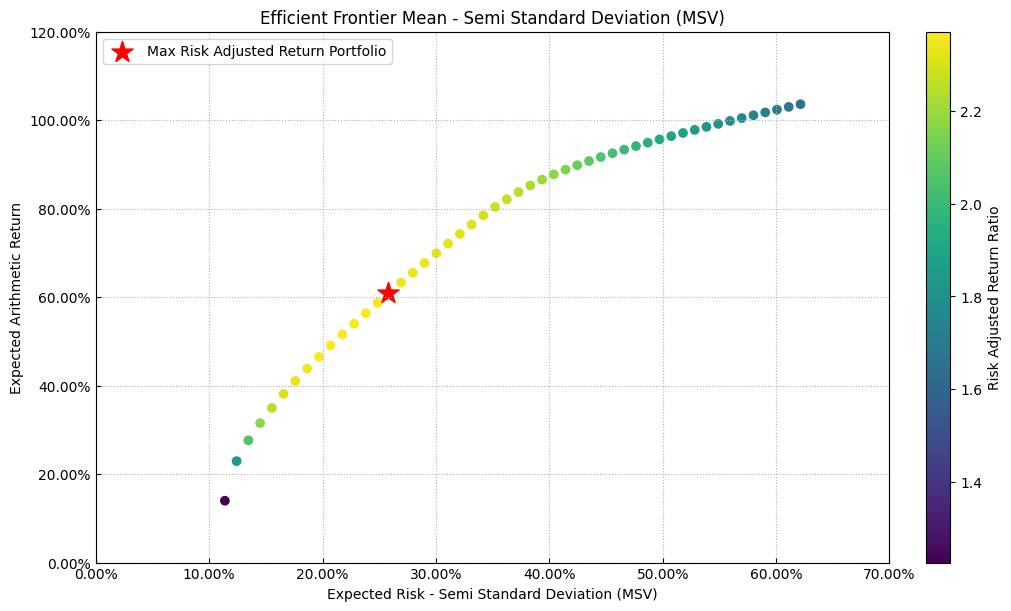

In [ ]:
label = 'Max Risk Adjusted Return Portfolio'
returns = port.returns

# Elegir la medida de riesgo
rm = 'MSV'  # Semi Standard Deviation

# (1) Asegurar que se estiman mu y cov con los métodos deseados antes de usarlos
port.assets_stats(method_mu='hist', method_cov='hist')
mu = port.mu
cov = port.cov

# (2) Usar la misma rf que en tus métricas para la frontera (consistencia con Sharpe/Sortino)
ws = port.efficient_frontier(model='Classic', rm=rm, points=50, rf=risk_free_rate_daily, hist=True)

ax = rp.PlotFunctions.plot_frontier(
    w_frontier=ws,
    mu=mu,
    cov=cov,
    returns=returns,
    rm=rm,
    rf=risk_free_rate_daily,
    alpha=0.05,
    cmap='viridis',
    w=w,
    label=label,
    marker='*',
    s=16,
    c='r',
    height=6,
    width=10,
    t_factor=252,
    ax=None
)

	•	Un frente eficiente en el plano Rentabilidad esperada (Y) vs Semidesviación estándar (X), ambos anualizados (por t_factor=252).
	•	La curva muestra las carteras eficientes para la medida de riesgo MSV (downside).
	•	Con rf=risk_free_rate_daily, se traza la línea del mercado de capitales (tangente) y se calculan razones ajustadas por riesgo de forma coherente (tipo Sortino/Sharpe según el caso).
	•	Tu cartera objetivo w aparece marcada con una estrella roja (marker='*', c='r', s=16) y la etiqueta Max Risk Adjusted Return Portfolio.
	•	El colormap viridis colorea los puntos de la frontera (p. ej., por nivel de riesgo/retorno según la función), y alpha=0.05 es el nivel de confianza usado por algunas medidas; para MSV no afecta el cálculo del riesgo.

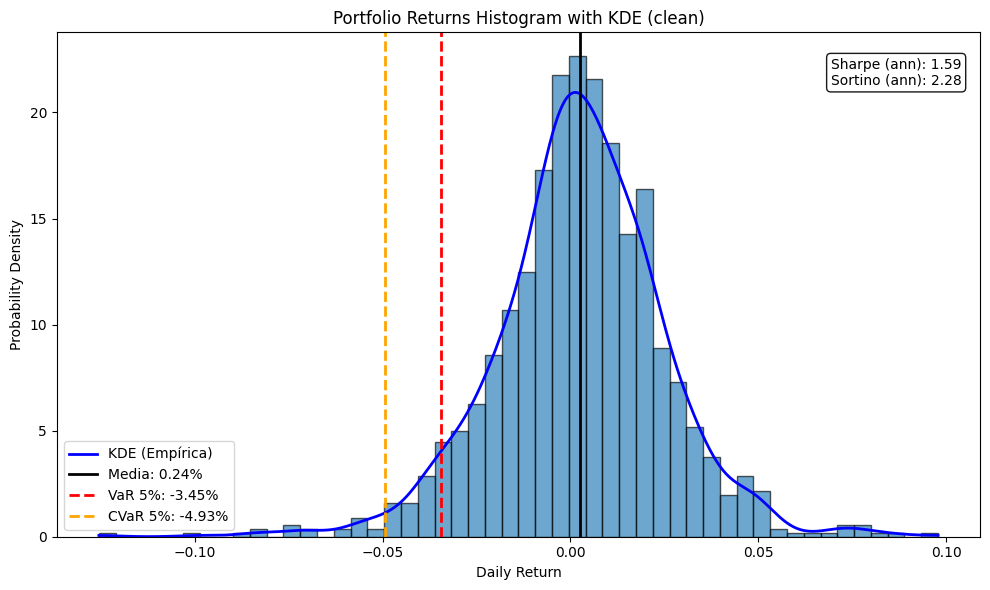

In [ ]:
# --- Retornos de la cartera ---
port_ret = returns.dot(w)
rf = risk_free_rate_daily
alpha = 0.05

# --- Métricas clave ---
mean_d = port_ret.mean()
std_d  = port_ret.std(ddof=1)
downside_std = port_ret[port_ret < 0].std(ddof=1)

sharpe = ((mean_d - rf) / std_d) * np.sqrt(252)
sortino = ((mean_d - rf) / downside_std) * np.sqrt(252) if downside_std > 0 else np.nan

var = np.percentile(port_ret, 100*alpha)
cvar = port_ret[port_ret <= var].mean()

# --- Preparar KDE ---
x_vals = np.linspace(port_ret.min(), port_ret.max(), 500)
kde = gaussian_kde(port_ret)
kde_vals = kde(x_vals)

# --- Plot ---
fig, ax = plt.subplots(figsize=(10, 6))

# Histograma
ax.hist(port_ret, bins=50, density=True, alpha=0.65, edgecolor='black')

# KDE
ax.plot(x_vals, kde_vals, color='blue', linewidth=2, label='KDE (Empírica)')

# Líneas de referencia
ax.axvline(mean_d, color='black', linewidth=2, label=f'Media: {mean_d:.2%}')
ax.axvline(var,   color='red', linestyle='--', linewidth=2, label=f'VaR 5%: {var:.2%}')
ax.axvline(cvar,  color='orange', linestyle='--', linewidth=2, label=f'CVaR 5%: {cvar:.2%}')

# Cuadro con Sharpe y Sortino
text = '\n'.join([
    f'Sharpe (ann): {sharpe:.2f}',
    f'Sortino (ann): {sortino:.2f}'
])
ax.text(0.98, 0.95, text, transform=ax.transAxes,
        ha='right', va='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))

# Etiquetas y título
ax.set_title('Portfolio Returns Histogram with KDE (clean)')
ax.set_xlabel('Daily Return')
ax.set_ylabel('Probability Density')
ax.legend(loc='lower left')
plt.tight_layout()
plt.show()

	•	Un histograma de los retornos diarios de la cartera construida con los pesos w sobre la serie de retornos returns.
	•	Cada barra representa la frecuencia de retornos dentro de un rango, con 50 intervalos (bins=50).
	•	Incluye métricas de riesgo calculadas a un nivel de confianza del 5% (alpha=0.05), como el Value at Risk (VaR) y el Conditional Value at Risk (CVaR), que suelen mostrarse como líneas verticales en el histograma.
	•	Es útil para visualizar la distribución de retornos y ver si tiene sesgo, colas pesadas o comportamientos extremos que podrían afectar al riesgo de la cartera.

    •	Se genera el histograma de retornos diarios con rp.plot_hist.
	•	Se calculan Sharpe anualizado y Sortino anualizado.
	•	Se añaden líneas verticales para la media, VaR y CVaR.
	•	Se anota la caja de texto con Sharpe y Sortino en la esquina superior derecha.

🚀 Iniciando cálculo del valor del portafolio...

==================== Buy & Hold ====================
📊 Calculando valor del portafolio:
   • Capital inicial: $100,000.00
   • Activos activos: 9
   • Período: 2020-01-02 a 2024-12-30
   • Días de trading: 1257
   • Estrategia: Buy & Hold (sin rebalanceo)
🏦 RESUMEN COMPLETO DEL PORTAFOLIO

💰 CAPITAL Y RETORNOS:
   Capital inicial:        $100,000.00
   Valor final:           $1,378,786.26
   Ganancia/Pérdida:      $1,278,786.26
   Retorno total:         1278.79%
   CAGR:                  69.22%

⚡ RIESGO:
   Volatilidad anualizada: 42.77%
   Máximo drawdown:       -53.15%

🎯 RATIOS:
   Sharpe Ratio:          1.3532
   Calmar Ratio:          1.3023

📅 PERÍODO:
   Duración:              4.99 años (1257 días)

🎯 COMPOSICIÓN DEL PORTAFOLIO:
   ----------------------------------------
   NVDA           :  34.83%
   AXON           :  14.46%
   COST           :  14.25%
   MSTR           :  12.90%
   GILD           :   7.94%
   TSLA           : 

/tmp/ipython-input-2009609175.py:69: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  rebalance_dates = prices_filtered.resample(rebalance_freq).last().index


🏦 RESUMEN COMPLETO DEL PORTAFOLIO

💰 CAPITAL Y RETORNOS:
   Capital inicial:        $100,000.00
   Valor final:           $1,245,349.33
   Ganancia/Pérdida:      $1,145,349.33
   Retorno total:         1145.35%
   CAGR:                  65.80%

⚡ RIESGO:
   Volatilidad anualizada: 35.64%
   Máximo drawdown:       -48.07%

🎯 RATIOS:
   Sharpe Ratio:          1.4884
   Calmar Ratio:          1.3687

📅 PERÍODO:
   Duración:              4.99 años (1257 días)

🎯 COMPOSICIÓN DEL PORTAFOLIO:
   ----------------------------------------
   NVDA           :  34.83%
   AXON           :  14.46%
   COST           :  14.25%
   MSTR           :  12.90%
   GILD           :   7.94%
   TSLA           :   7.32%
   ORLY           :   5.82%
   TMUS           :   2.08%
   PDD            :   0.40%

==================== Rebalanceo Trimestral ====================
📊 Calculando valor del portafolio:
   • Capital inicial: $100,000.00
   • Activos activos: 9
   • Período: 2020-01-02 a 2024-12-30
   • Días de trad

/tmp/ipython-input-2009609175.py:69: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  rebalance_dates = prices_filtered.resample(rebalance_freq).last().index


🏦 RESUMEN COMPLETO DEL PORTAFOLIO

💰 CAPITAL Y RETORNOS:
   Capital inicial:        $100,000.00
   Valor final:           $1,446,564.65
   Ganancia/Pérdida:      $1,346,564.65
   Retorno total:         1346.56%
   CAGR:                  70.85%

⚡ RIESGO:
   Volatilidad anualizada: 37.85%
   Máximo drawdown:       -44.42%

🎯 RATIOS:
   Sharpe Ratio:          1.5025
   Calmar Ratio:          1.5951

📅 PERÍODO:
   Duración:              4.99 años (1257 días)

🎯 COMPOSICIÓN DEL PORTAFOLIO:
   ----------------------------------------
   NVDA           :  34.83%
   AXON           :  14.46%
   COST           :  14.25%
   MSTR           :  12.90%
   GILD           :   7.94%
   TSLA           :   7.32%
   ORLY           :   5.82%
   TMUS           :   2.08%
   PDD            :   0.40%

📊 COMPARACIÓN DE ESCENARIOS
                      Valor Final Retorno Total    CAGR  Sharpe   Max DD
Buy & Hold             $1,378,786      1278.79%  69.22%  1.3532  -53.15%
Rebalanceo Mensual     $1,245,349     

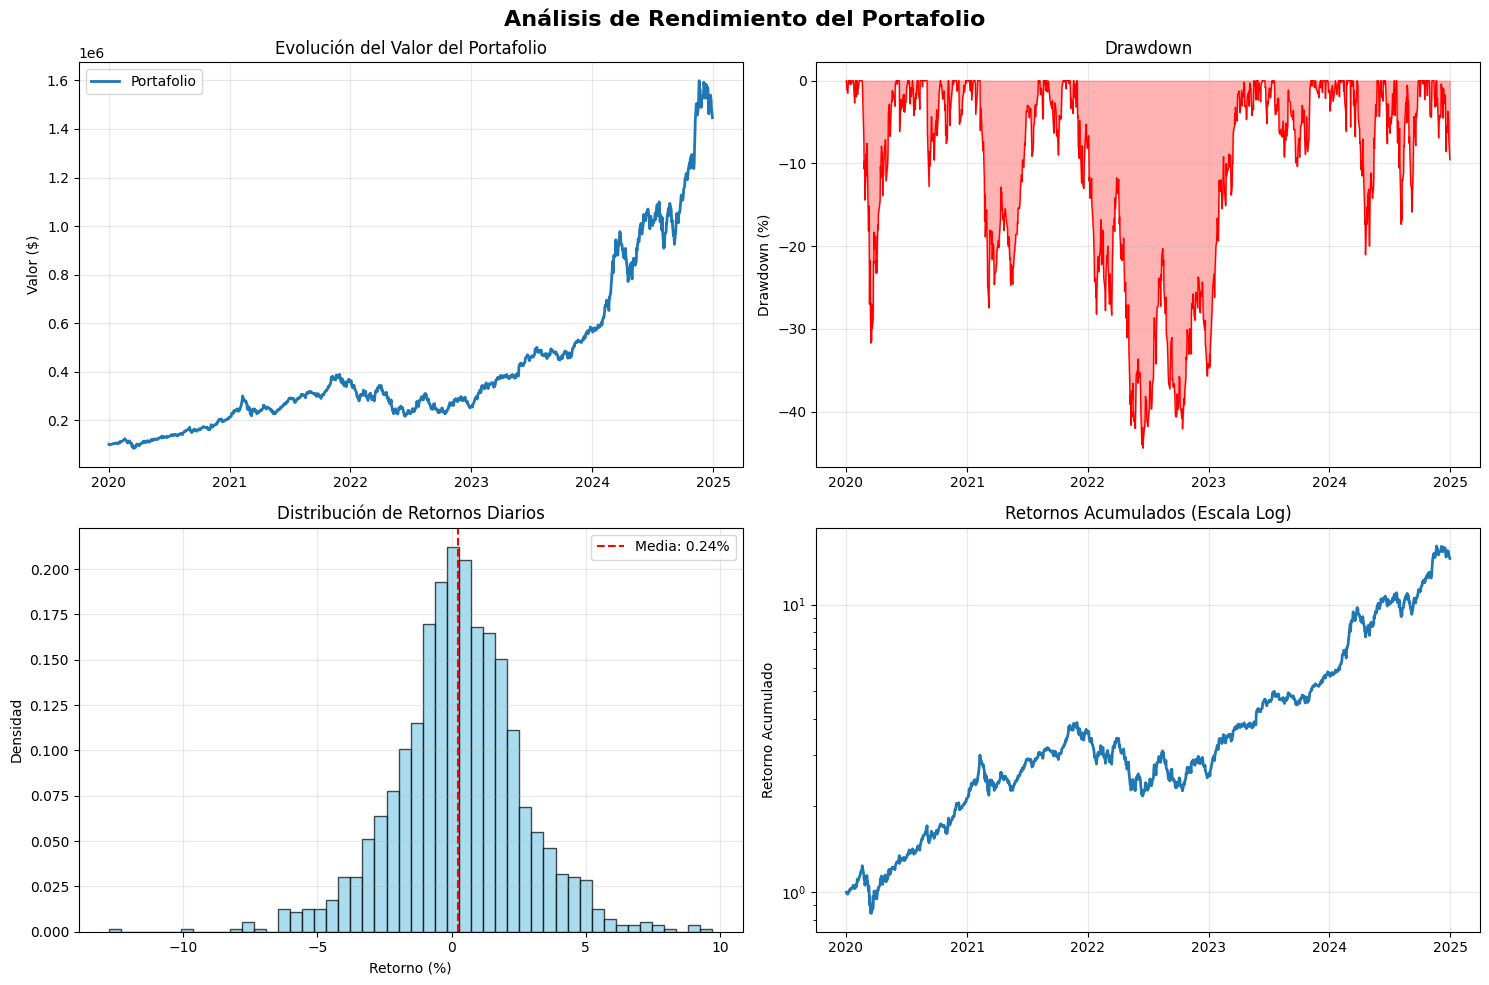

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# =========================
# Portfolio Value Calculation (VectorBT Style)
# =========================

def calculate_portfolio_value(prices, weights, initial_capital=100000, rebalance_freq=None):
    """
    Calcula el valor del portafolio usando pesos fijos o con rebalanceo

    Parameters:
    -----------
    prices : pd.DataFrame
        Precios de los activos (fechas x activos)
    weights : pd.Series
        Pesos del portafolio (suma = 1)
    initial_capital : float
        Capital inicial
    rebalance_freq : str, optional
        Frecuencia de rebalanceo ('D', 'W', 'M', 'Q', None)
        Si None, no hay rebalanceo (buy & hold)

    Returns:
    --------
    dict con métricas y series temporales
    """

    # Asegurar que los pesos suman 1
    weights = weights / weights.sum()

    # Filtrar precios solo para los activos con peso > 0
    active_assets = weights[weights > 0].index
    prices_filtered = prices[active_assets].dropna()
    weights_filtered = weights[active_assets]

    print(f"📊 Calculando valor del portafolio:")
    print(f"   • Capital inicial: ${initial_capital:,.2f}")
    print(f"   • Activos activos: {len(active_assets)}")
    print(f"   • Período: {prices_filtered.index[0].strftime('%Y-%m-%d')} a {prices_filtered.index[-1].strftime('%Y-%m-%d')}")
    print(f"   • Días de trading: {len(prices_filtered)}")

    if rebalance_freq is None:
        # Método 1: Buy & Hold (sin rebalanceo)
        print(f"   • Estrategia: Buy & Hold (sin rebalanceo)")

        # Calcular retornos diarios
        returns = prices_filtered.pct_change().fillna(0)

        # Valor inicial de cada posición
        initial_positions = weights_filtered * initial_capital

        # Número de acciones compradas inicialmente
        shares = initial_positions / prices_filtered.iloc[0]

        # Valor diario del portafolio = suma de (shares * precio_diario)
        portfolio_value = (shares * prices_filtered).sum(axis=1)

        # Métricas
        total_return = (portfolio_value.iloc[-1] / portfolio_value.iloc[0]) - 1

    else:
        # Método 2: Con rebalanceo periódico
        print(f"   • Estrategia: Rebalanceo {rebalance_freq}")

        # Crear fechas de rebalanceo
        rebalance_dates = prices_filtered.resample(rebalance_freq).last().index

        portfolio_value = pd.Series(index=prices_filtered.index, dtype=float)
        portfolio_value.iloc[0] = initial_capital

        current_capital = initial_capital

        for i in range(len(prices_filtered)):
            current_date = prices_filtered.index[i]

            # Si es fecha de rebalanceo, recalcular posiciones
            if i == 0 or current_date in rebalance_dates:
                current_positions = weights_filtered * current_capital
                shares = current_positions / prices_filtered.iloc[i]

            # Calcular valor actual
            portfolio_value.iloc[i] = (shares * prices_filtered.iloc[i]).sum()
            current_capital = portfolio_value.iloc[i]

        total_return = (portfolio_value.iloc[-1] / portfolio_value.iloc[0]) - 1

    # Calcular métricas adicionales
    returns_pct = portfolio_value.pct_change().fillna(0)

    # Métricas de rendimiento
    n_days = len(portfolio_value)
    n_years = n_days / 252
    cagr = (portfolio_value.iloc[-1] / portfolio_value.iloc[0]) ** (1/n_years) - 1

    # Volatilidad
    volatility_daily = returns_pct.std()
    volatility_annual = volatility_daily * np.sqrt(252)

    # Drawdown
    running_max = portfolio_value.expanding().max()
    drawdown = (portfolio_value - running_max) / running_max
    max_drawdown = drawdown.min()

    # Sharpe ratio (asumiendo 4% risk-free)
    risk_free_daily = (1.04 ** (1/252)) - 1
    excess_returns = returns_pct - risk_free_daily
    sharpe_ratio = excess_returns.mean() / excess_returns.std() * np.sqrt(252)

    # Calmar ratio
    calmar_ratio = cagr / abs(max_drawdown) if max_drawdown != 0 else np.inf

    return {
        'portfolio_value': portfolio_value,
        'returns': returns_pct,
        'drawdown': drawdown,
        'weights': weights_filtered,
        'active_assets': active_assets,
        'metrics': {
            'initial_capital': initial_capital,
            'final_value': portfolio_value.iloc[-1],
            'total_return': total_return,
            'cagr': cagr,
            'volatility_annual': volatility_annual,
            'max_drawdown': max_drawdown,
            'sharpe_ratio': sharpe_ratio,
            'calmar_ratio': calmar_ratio,
            'n_years': n_years,
            'n_days': n_days
        }
    }

def plot_portfolio_performance(portfolio_results, benchmark_prices=None, benchmark_name="Benchmark"):
    """
    Grafica el rendimiento del portafolio
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Análisis de Rendimiento del Portafolio', fontsize=16, fontweight='bold')

    portfolio_value = portfolio_results['portfolio_value']
    drawdown = portfolio_results['drawdown']
    returns = portfolio_results['returns']

    # 1. Evolución del valor del portafolio
    ax1 = axes[0, 0]
    ax1.plot(portfolio_value.index, portfolio_value.values, linewidth=2, label='Portafolio')

    # Agregar benchmark si se proporciona
    if benchmark_prices is not None:
        benchmark_norm = benchmark_prices / benchmark_prices.iloc[0] * portfolio_results['metrics']['initial_capital']
        ax1.plot(benchmark_norm.index, benchmark_norm.values, linewidth=2, alpha=0.7, label=benchmark_name)

    ax1.set_title('Evolución del Valor del Portafolio')
    ax1.set_ylabel('Valor ($)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # 2. Drawdown
    ax2 = axes[0, 1]
    ax2.fill_between(drawdown.index, drawdown.values * 100, 0, alpha=0.3, color='red')
    ax2.plot(drawdown.index, drawdown.values * 100, color='red', linewidth=1)
    ax2.set_title('Drawdown')
    ax2.set_ylabel('Drawdown (%)')
    ax2.grid(True, alpha=0.3)

    # 3. Distribución de retornos diarios
    ax3 = axes[1, 0]
    returns_pct = returns * 100
    ax3.hist(returns_pct.values, bins=50, alpha=0.7, density=True, color='skyblue', edgecolor='black')
    ax3.axvline(returns_pct.mean(), color='red', linestyle='--', label=f'Media: {returns_pct.mean():.2f}%')
    ax3.set_title('Distribución de Retornos Diarios')
    ax3.set_xlabel('Retorno (%)')
    ax3.set_ylabel('Densidad')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # 4. Retornos acumulados (escala log)
    ax4 = axes[1, 1]
    cumulative_returns = (1 + returns).cumprod()
    ax4.semilogy(cumulative_returns.index, cumulative_returns.values, linewidth=2)
    ax4.set_title('Retornos Acumulados (Escala Log)')
    ax4.set_ylabel('Retorno Acumulado')
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def print_portfolio_summary(portfolio_results):
    """
    Imprime un resumen completo del portafolio
    """
    metrics = portfolio_results['metrics']
    weights = portfolio_results['weights']

    print("=" * 80)
    print("🏦 RESUMEN COMPLETO DEL PORTAFOLIO")
    print("=" * 80)

    print(f"\n💰 CAPITAL Y RETORNOS:")
    print(f"   Capital inicial:        ${metrics['initial_capital']:,.2f}")
    print(f"   Valor final:           ${metrics['final_value']:,.2f}")
    print(f"   Ganancia/Pérdida:      ${metrics['final_value'] - metrics['initial_capital']:,.2f}")
    print(f"   Retorno total:         {metrics['total_return']:.2%}")
    print(f"   CAGR:                  {metrics['cagr']:.2%}")

    print(f"\n⚡ RIESGO:")
    print(f"   Volatilidad anualizada: {metrics['volatility_annual']:.2%}")
    print(f"   Máximo drawdown:       {metrics['max_drawdown']:.2%}")

    print(f"\n🎯 RATIOS:")
    print(f"   Sharpe Ratio:          {metrics['sharpe_ratio']:.4f}")
    print(f"   Calmar Ratio:          {metrics['calmar_ratio']:.4f}")

    print(f"\n📅 PERÍODO:")
    print(f"   Duración:              {metrics['n_years']:.2f} años ({metrics['n_days']} días)")

    print(f"\n🎯 COMPOSICIÓN DEL PORTAFOLIO:")
    print("   " + "-" * 40)
    for asset, weight in weights.sort_values(ascending=False).items():
        print(f"   {asset:15s}: {weight:7.2%}")

    print("=" * 80)

# =========================
# EJEMPLO DE USO
# =========================

# Asumiendo que tienes 'prices', 'w' (pesos) del código anterior
if 'prices' in locals() and 'w' in locals():
    print("🚀 Iniciando cálculo del valor del portafolio...")

    # Filtrar el período de interés
    start_date = "2020-01-01"
    end_date = "2024-12-31"
    prices_period = prices.loc[start_date:end_date]

    # Calcular diferentes escenarios
    scenarios = {
        'Buy & Hold': None,
        'Rebalanceo Mensual': 'M',
        'Rebalanceo Trimestral': 'Q'
    }

    results = {}

    for scenario_name, rebal_freq in scenarios.items():
        print(f"\n{'='*20} {scenario_name} {'='*20}")

        results[scenario_name] = calculate_portfolio_value(
            prices=prices_period,
            weights=w,
            initial_capital=100000,
            rebalance_freq=rebal_freq
        )

        print_portfolio_summary(results[scenario_name])

    # Comparar escenarios
    print("\n" + "="*80)
    print("📊 COMPARACIÓN DE ESCENARIOS")
    print("="*80)

    comparison_df = pd.DataFrame({
        scenario: {
            'Valor Final': f"${res['metrics']['final_value']:,.0f}",
            'Retorno Total': f"{res['metrics']['total_return']:.2%}",
            'CAGR': f"{res['metrics']['cagr']:.2%}",
            'Sharpe': f"{res['metrics']['sharpe_ratio']:.4f}",
            'Max DD': f"{res['metrics']['max_drawdown']:.2%}"
        }
        for scenario, res in results.items()
    }).T

    print(comparison_df)

    # Graficar el mejor escenario
    best_scenario = max(results.keys(), key=lambda x: results[x]['metrics']['sharpe_ratio'])
    print(f"\n🏆 Mejor escenario por Sharpe Ratio: {best_scenario}")

    plot_portfolio_performance(results[best_scenario])

else:
    print("⚠️ Asegúrate de tener definidos 'prices' y 'w' (pesos) antes de ejecutar este código")
    print("El DataFrame 'prices' debe contener los precios de los activos")
    print("La Series 'w' debe contener los pesos del portafolio")